In [1]:
#imports
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam
from functions.ep_optimizers import EpochEVE_allparams
#from functions.eve_optimizer import GD_EVE, GD_EVE_mb, GD_EVE2_mb, GD_EVE2_allparams_mb, GD_EVE_mb_shuff, GD_EVE2_mb_shuff, EpochEVE, EpochEVE2, EpochEVE3

In [2]:
#AllCNN imports
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

In [3]:
batch_size = 128

#time_lim = 1000
num_epochs = 100

lr = 1.5e-5
betas = (0.9, 0.999)

In [4]:
!nvidia-smi

Fri Aug 27 03:47:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |   8837MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [5]:
device = 'cuda:2'

In [6]:
## This is used when training with the new KDE
train_data = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            #'/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            slice = slice(None,60000)
                           )

EVE_data = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            #'/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            slice = slice(60000,None)
                           )

test_data = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            masking=True, shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 16.97 s
Constructing 60000 event dataset took 8.198 s
Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 16.69 s
Constructing 20000 event dataset took 0.2159 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 4.335 s
Constructing 20000 event dataset took 0.2114 s


In [7]:
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

model = Model()
model.to(device)

loss_fn = Loss(epsilon=1e-5,coefficient=2.5)

In [8]:
param_states = []
train_losses = []
#train_accs = []
test_losses = []
#test_accs = []
step_scalars = []
ep_times = []
adam_step_sizes = []

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    step_sizes = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        g, m1, m2, step_size = optimizer.step()
        step_sizes.append(step_size)

    return step_sizes

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    return test_loss/len(dataloader)

In [10]:
#Choose optimizer
optimizer = Adam(model.parameters(), lr=lr, betas=betas)
ep_optimizer = EpochEVE_allparams(model.parameters(), model, loss_fn, EVE_data, device)

#getting initial param state
param_states.append(get_param_state(model))

#Getting initial train and test loss
l = test(train_data, model, loss_fn)
train_losses.append(l)
#train_accs.append(a)
l = test(test_data, model, loss_fn)
test_losses.append(l)
#test_accs.append(a)

#initial time is 0
ep_times.append(0)

#epoch index
total_time = 0
j = 0
while j < num_epochs:
#while total_time < time_lim:
    start_time = time.time()
    print(' - Epoch: %i'%(j+1))

    #run minibatch optimizer
    these_adam_step_sizes = train(train_data, model, loss_fn, optimizer)
    print("Adam took", time.time()-start_time, 's')
    
    #apply epoch optimizer
    if ep_optimizer is not None and j > 10:
        these_step_scalars = ep_optimizer.step()
    print('Epoch took',time.time()-start_time ,'s')
        
    total_time += time.time()-start_time
    #get metrics and parameter states of model after this epoch
    if ep_optimizer is not None and j > 10:
        step_scalars.append(these_step_scalars)
    ep_times.append(total_time)
    adam_step_sizes = adam_step_sizes + these_adam_step_sizes
    param_states.append(get_param_state(model))
    
    l = test(train_data, model, loss_fn)
    train_losses.append(l)
    #train_accs.append(a)
    
    l = test(test_data, model, loss_fn)
    test_losses.append(l)
    #test_accs.append(a)

    j += 1
    

# step_scalars.append(this_step_scalars)
# train_losses.append(np.array(this_train_loss))
# test_losses.append(np.array(this_test_loss))
# test_acc.append(np.array(this_test_acc))
# train_times.append(np.array(this_train_times))
# test_times.append(np.array(this_test_times))
# param_states.append(np.array(this_param_states))

 - Epoch: 1
Adam took 83.61019515991211 s
Epoch took 83.61044454574585 s
 - Epoch: 2
Adam took 89.97507357597351 s
Epoch took 89.9753737449646 s
 - Epoch: 3
Adam took 91.93028140068054 s
Epoch took 91.93056201934814 s
 - Epoch: 4
Adam took 94.76876306533813 s
Epoch took 94.76901268959045 s
 - Epoch: 5
Adam took 104.71359038352966 s
Epoch took 104.71385073661804 s
 - Epoch: 6
Adam took 104.37436604499817 s
Epoch took 104.37459707260132 s
 - Epoch: 7
Adam took 113.55003261566162 s
Epoch took 113.55027055740356 s
 - Epoch: 8
Adam took 120.07742953300476 s
Epoch took 120.07768893241882 s
 - Epoch: 9
Adam took 121.1125135421753 s
Epoch took 121.11286282539368 s
 - Epoch: 10
Adam took 119.90720438957214 s
Epoch took 119.90747308731079 s
 - Epoch: 11
Adam took 118.6820809841156 s
Epoch took 118.68231105804443 s
 - Epoch: 12
Adam took 114.087167263031 s
Epoch took 137.75555205345154 s
 - Epoch: 13
Adam took 107.10552835464478 s
Epoch took 125.56387782096863 s
 - Epoch: 14
Adam took 103.3379547

MemoryError: Unable to allocate array with shape (101, 16010601) and data type float64

In [11]:
param_states = np.asarray(param_states)
steps = param_states[1:] - param_states[:-1]   

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


step scalars: [[0], [4], [0], [1], [0.5], [0.5], [0.5], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0.5], [1], [4], [0], [1], [1], [0.5], [1], [0.5], [0], [0], [2], [0.5], [1], [0.5], [1], [0.5], [1], [0.5], [0.5], [0.5], [0.5], [0], [1], [0], [0], [0.5], [0], [0], [0.5], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0.5], [0], [0], [0.5], [0], [0], [0], [0], [0], [0], [0], [0.5], [0], [0], [0], [0.5], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0.5], [0]]


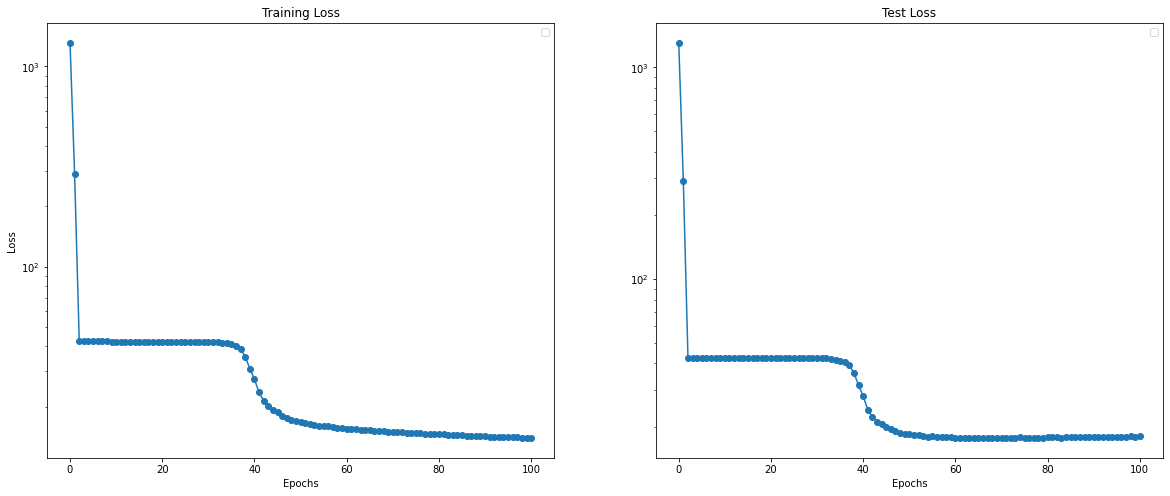

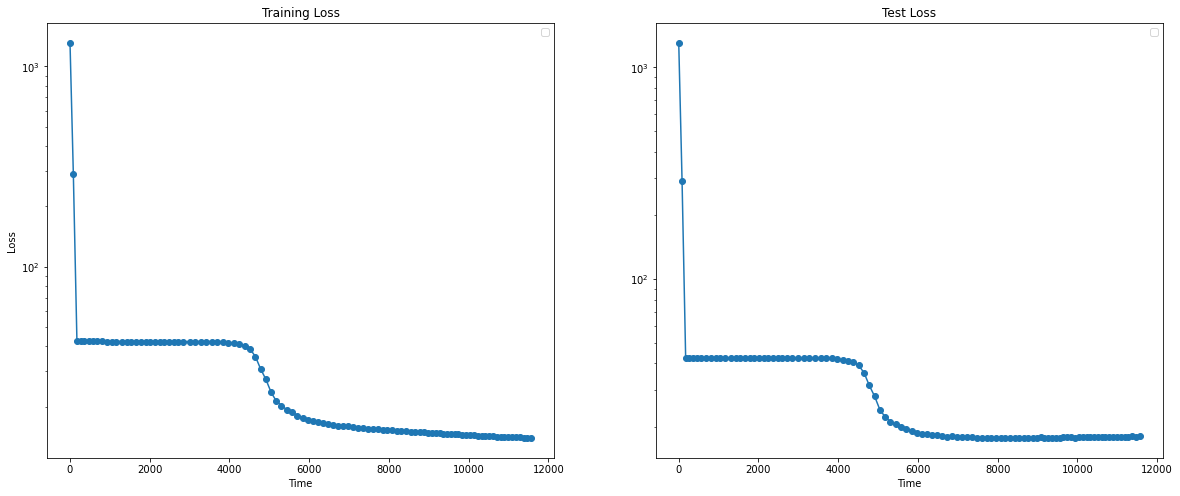

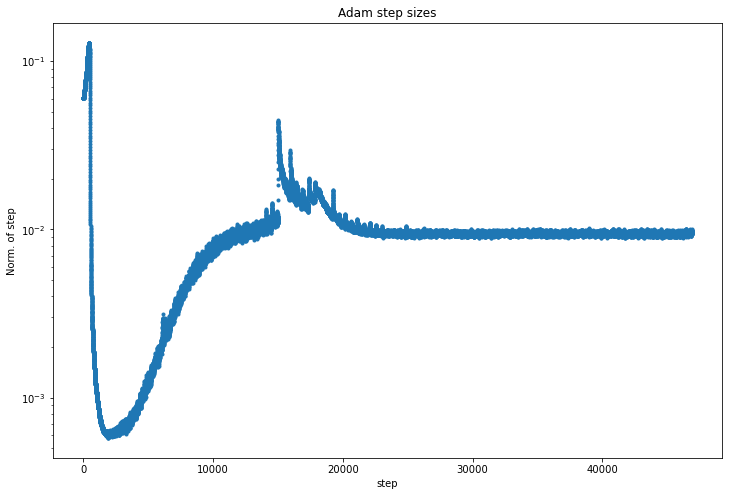

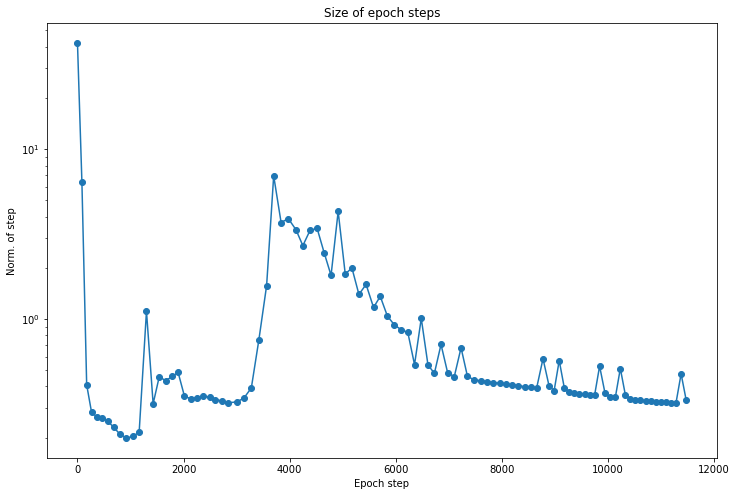

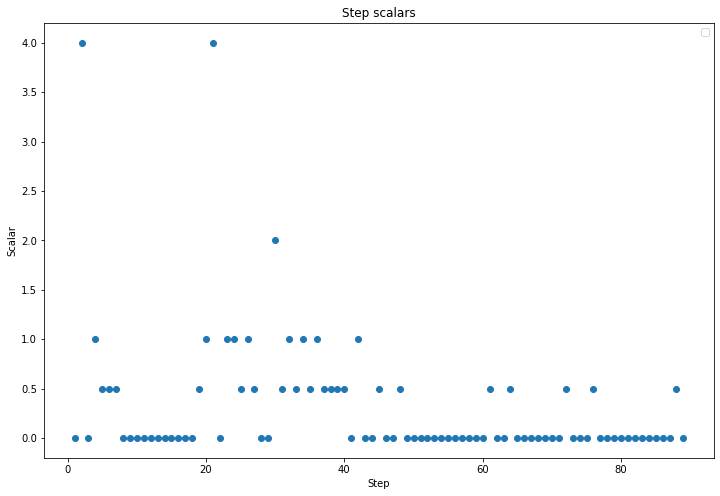

In [12]:
#plotting loss over training
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.plot(train_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()
#plotting loss over testing
plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.plot(test_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()
##########################################################

#plotting loss over training
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('Training Loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.yscale('log')
plt.plot(ep_times, train_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()

#plotting loss over testing
plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.xlabel('Time')
plt.yscale('log')
plt.plot(ep_times, test_losses, 'o-')#, label=trial_labels[trial], color=trial_colors[trial])
plt.legend()

#plotting adam step sizes
plt.figure(figsize=(12,8))
plt.title("Adam step sizes")
plt.xlabel("step")
plt.ylabel("Norm. of step")
plt.yscale('log')
plt.plot(adam_step_sizes, '.')

#plotting size of epoch step
plt.figure(figsize=(12,8))
plt.title("Size of epoch steps")
plt.xlabel("Epoch step")
plt.ylabel("Norm. of step")
plt.yscale('log')
plt.plot(ep_times[:-1], [np.linalg.norm(step) for step in steps], 'o-')

#plotting step scalars over time
print('step scalars:', step_scalars)
plt.figure(figsize=(12,8))
if len(step_scalars) > 0:
    #plt.figure(figsize=(12,8))
    plt.title('Step scalars')
    plt.ylabel('Scalar')
    plt.xlabel('Step')
    plt.scatter([i+1 for i in range(len(step_scalars))], step_scalars)#, label=trial_labels[trial], c=[trial_colors[trial] for i in range(len(step_scalars[trial]))])
    plt.legend()

In [13]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [14]:
def angle_between(i, j, epoch_steps):
    if i == j:
        return 0
    else:
        #print(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))
        return np.arccos(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))

this_grid_size = len(param_states)-1
angle_grid = np.zeros((this_grid_size, this_grid_size))
for i in range(this_grid_size):
    for j in range(this_grid_size):
        angle_grid[i, j] = angle_between(i, j, epoch_steps = steps)

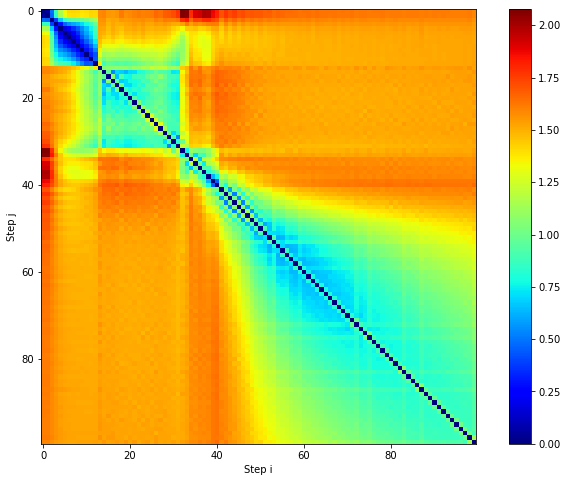

<Figure size 864x576 with 0 Axes>

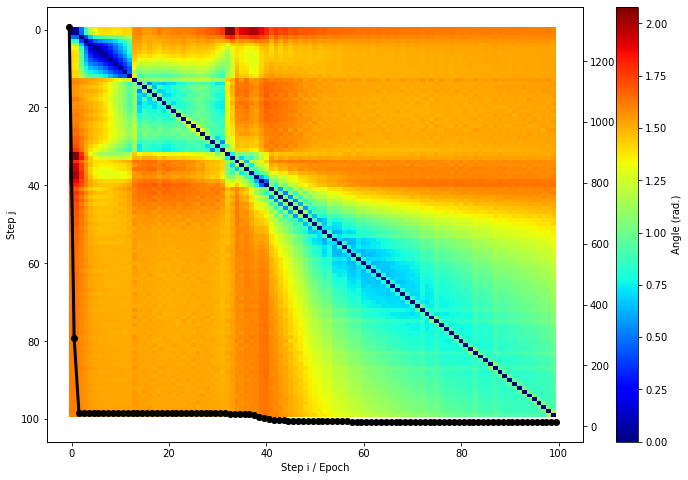

In [15]:
plt.figure(figsize=(12,8))

norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   

plt.imshow(angle_grid, cmap=cm.jet)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
plt.xlabel('Step i')
plt.ylabel('Step j')

plt.figure(figsize=(12,8))

norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))  
fig,ax = plt.subplots(figsize=(12,8))
#ax.set_ylabel("Training loss")
ax.set_xlabel("Epoch")
#plt.plot(train_losses, 'go-')
ax.imshow(angle_grid, cmap=cm.jet)
ax.set_ylim((100, 0))
ax2 = ax.twinx()
#ax.set_ylim((100, 0))
ax.set_aspect(0.80)
ax.set_ylabel('Step j')
ax2.set_ylabel('Train loss')
ax.set_xlabel("Step i / Epoch")
ax.set_xlim((-0.05*num_epochs, 1.05*num_epochs))
#ax.set_ylim((100, 0))
ax2.plot([i-0.5 for i in range(num_epochs+1)], train_losses, 'ko-', linewidth=3, markersize=6)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet), ax=ax)
cbar.set_label('Angle (rad.)')
# plt.xlabel('Step i')
# plt.ylabel('Step j')

In [16]:
# #set shuffle to false, and recollect data to same variable avoid overloading GPU memory
# train_data = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
#                                   #'/share/lazy/will/data/June30_2020_80k_2.h5',
#                                   #'/share/lazy/will/data/June30_2020_80k_3.h5',
#                                   #'/share/lazy/will/data/June30_2020_80k_4.h5',
#                              batch_size=batch_size,
# ## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
# ## the dataset will overflow the GPU memory; device=device will allow the data to move back
# ## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
# ## down performance by about 10%.  So comment out when not needed.
#                           device=device,
# ##                           slice = slice(None,18000)
#                           shuffle=False
#                            )

import time 
def scan_ahead(state_idx, num_steps=1, steps=[2**i for i in range(-2, 4)], epoch_states=param_states):
    losses = []
    for step in steps:
        #print(epoch_states[state_idx].shape, (epoch_states[state_idx+num_steps]-epoch_states[state_idx]).shape)
        time0 = time.time()
        param_state = epoch_states[state_idx] + step*(epoch_states[state_idx+num_steps]-epoch_states[state_idx])
        print('Calc. p. state took', time.time()-time0, 's')
        time0 = time.time()
        model.load_state_dict(vector_to_state_dict(param_state, model))
        print('Loading model state took', time.time()-time0, 's')
        time0 = time.time()
        this_loss = test(train_data, model, loss_fn)
        print('Calc. loss on training data took', time.time()-time0, 's')
        losses.append(this_loss)
    return steps, losses

colors = cm.magma(np.linspace(0, 1, len(np.arange(0, num_epochs-1, 5))))


scan_losses = []
scan_steps = []
for i in np.arange(0, num_epochs-1, 5):
    this_scan_steps, this_scan_losses = scan_ahead(i)
    scan_losses.append(this_scan_losses)
    scan_steps.append(this_scan_steps)
    

Calc. p. state took 0.11849045753479004 s
Loading model state took 0.027585268020629883 s
Calc. loss on training data took 3.7202906608581543 s
Calc. p. state took 0.1280515193939209 s
Loading model state took 0.026595354080200195 s
Calc. loss on training data took 3.704547643661499 s
Calc. p. state took 0.13121724128723145 s
Loading model state took 0.02809882164001465 s
Calc. loss on training data took 3.7256312370300293 s
Calc. p. state took 0.129075288772583 s
Loading model state took 0.028455734252929688 s
Calc. loss on training data took 3.76336932182312 s
Calc. p. state took 0.1286914348602295 s
Loading model state took 0.054981231689453125 s
Calc. loss on training data took 3.759328603744507 s
Calc. p. state took 0.12858176231384277 s
Loading model state took 0.028482437133789062 s
Calc. loss on training data took 3.7131476402282715 s
Calc. p. state took 0.17914056777954102 s
Loading model state took 0.02891826629638672 s
Calc. loss on training data took 3.7107367515563965 s
Ca

Calc. loss on training data took 4.064579010009766 s
Calc. p. state took 0.13508152961730957 s
Loading model state took 0.028931617736816406 s
Calc. loss on training data took 4.19790506362915 s
Calc. p. state took 0.13174772262573242 s
Loading model state took 0.028721332550048828 s
Calc. loss on training data took 4.134402275085449 s
Calc. p. state took 0.2052018642425537 s
Loading model state took 0.05335736274719238 s
Calc. loss on training data took 4.169542551040649 s
Calc. p. state took 0.14661359786987305 s
Loading model state took 0.045949459075927734 s
Calc. loss on training data took 4.149712324142456 s
Calc. p. state took 0.14661526679992676 s
Loading model state took 0.045853614807128906 s
Calc. loss on training data took 4.11080002784729 s
Calc. p. state took 0.4273250102996826 s
Loading model state took 0.030224084854125977 s
Calc. loss on training data took 4.088690996170044 s
Calc. p. state took 0.13318300247192383 s
Loading model state took 0.028702974319458008 s
Calc

Calc. loss on training data took 4.158980131149292 s
Calc. p. state took 0.14678215980529785 s
Loading model state took 0.0519869327545166 s
Calc. loss on training data took 4.166768789291382 s
Calc. p. state took 0.14652490615844727 s
Loading model state took 0.03018808364868164 s
Calc. loss on training data took 4.176507472991943 s
Calc. p. state took 0.3757169246673584 s
Loading model state took 0.03018331527709961 s
Calc. loss on training data took 4.118069648742676 s
Calc. p. state took 0.1339719295501709 s
Loading model state took 0.03003835678100586 s
Calc. loss on training data took 4.2115867137908936 s


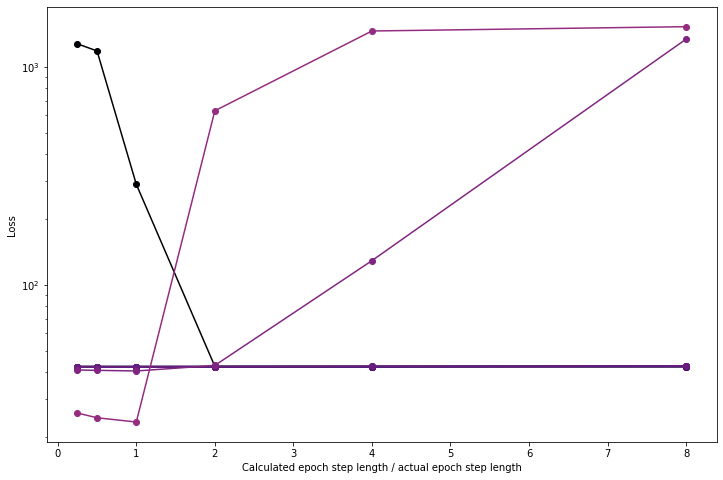

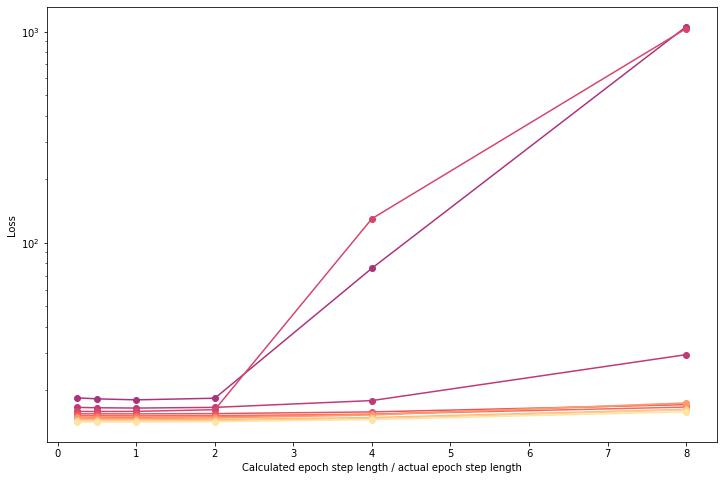

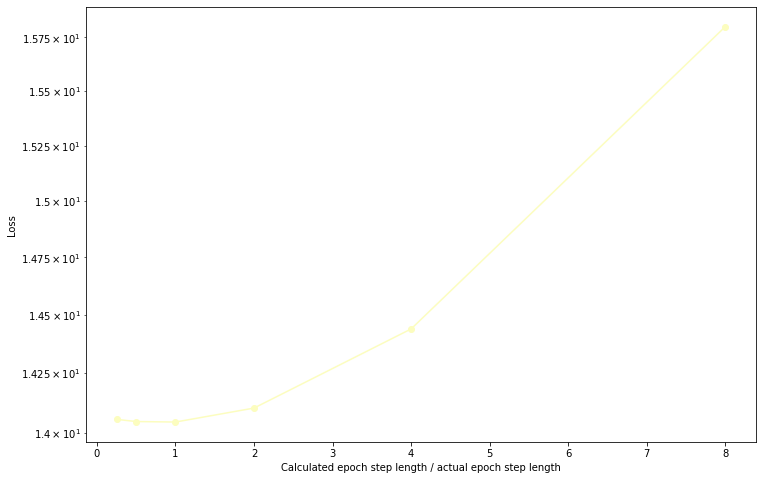

In [17]:
plt.figure(figsize=(12,8))
plt.xlabel('Calculated epoch step length / actual epoch step length')
plt.ylabel('Loss')
plt.yscale('log')
for i in range(len(np.arange(0, num_epochs-1, 5))):
    
    if (i+1) % 10 == 0:
        plt.figure(figsize=(12,8))
        plt.xlabel('Calculated epoch step length / actual epoch step length')
        plt.ylabel('Loss')
        plt.yscale('log')
        
    init_time = time.time()
    
    #print('time:', time.time()-init_time)
    plt.plot(scan_steps[i], scan_losses[i], 'o-', color=colors[i])

In [18]:
torch.save(model.state_dict(), 'AllCNN_8.24_1trialtemplate_EpEVE_ap_EVEdset_final.pyt')